In [2]:
import modern_robotics as mr
import numpy as np
np.set_printoptions(2)

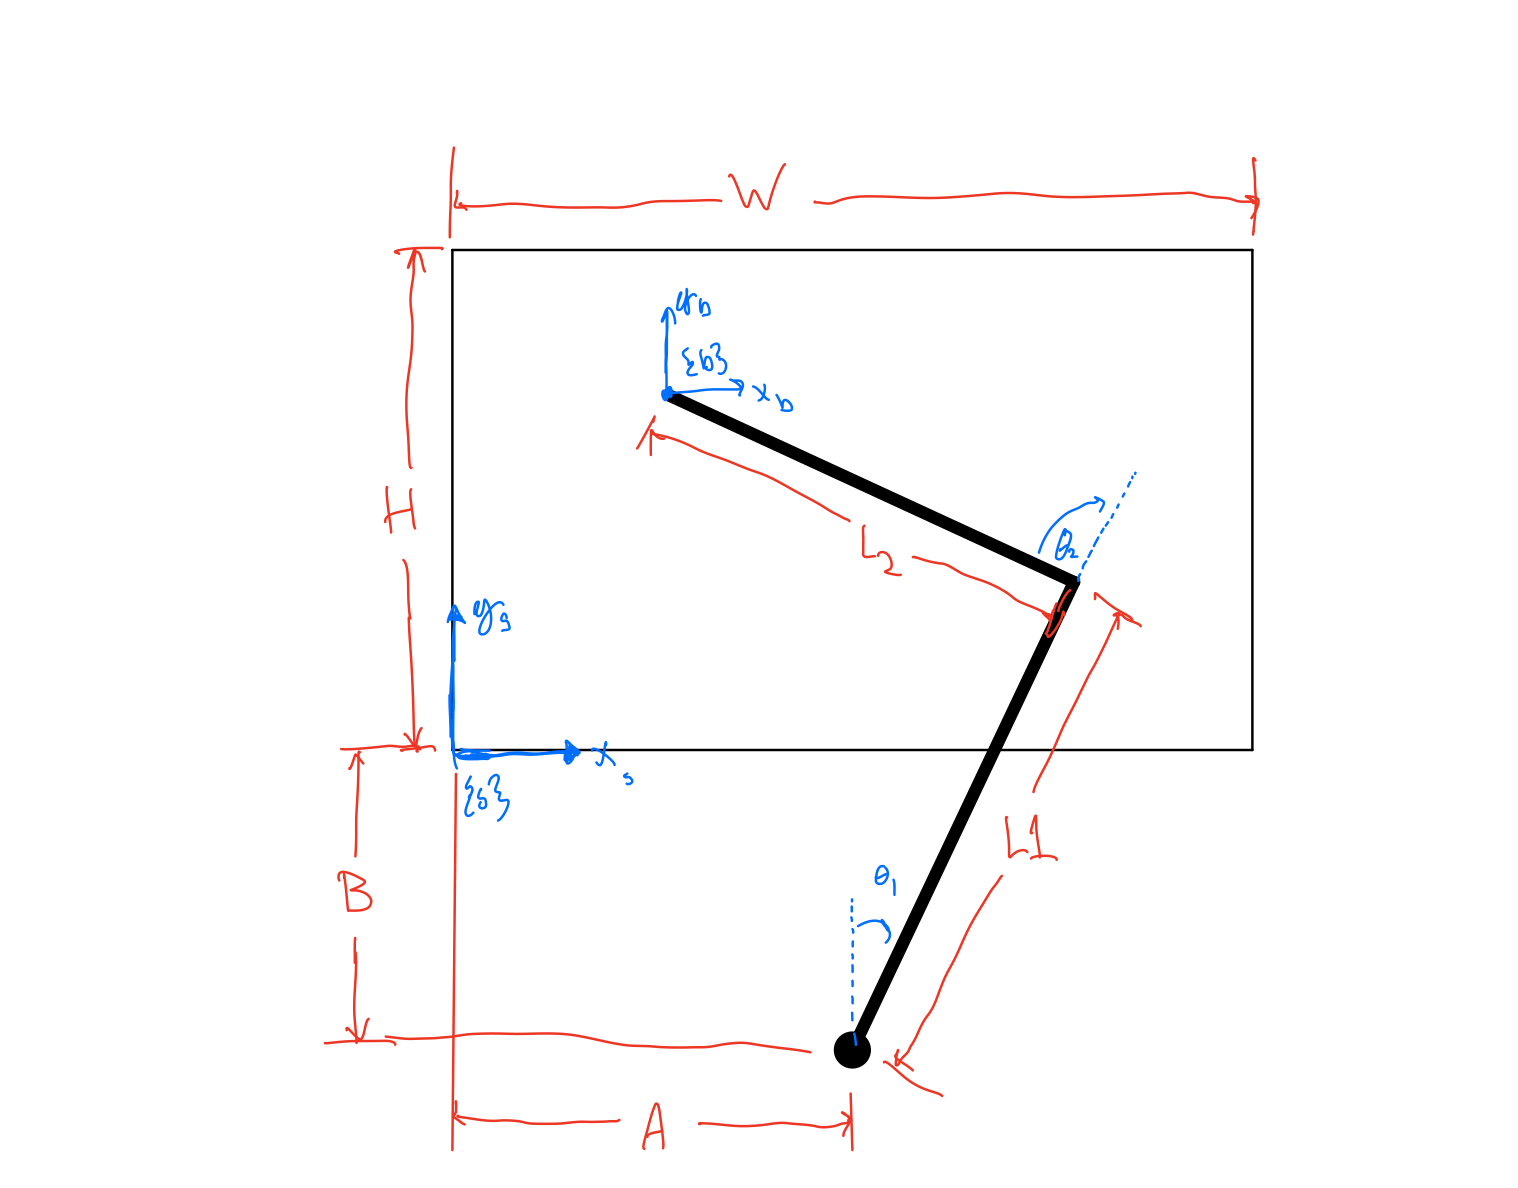

In [3]:
import matplotlib
from IPython.display import Image
Image('2R_Topology.png')


In [4]:
from math import atan, acos, sqrt
from numpy import pi

def atan2(x, y):
    x_a = abs(x)
    y_a = abs(y)

    if y == 0:
        if x >= 0: return 0
        else: return pi
    elif x == 0:
        if y > 0: return pi/2
        else: return 3*pi/2
    # Quadrant 1
    if x > 0 and y > 0:
        return atan(y_a/x_a)
    # Quadrant 2
    elif x < 0 and y > 0:
        return pi - atan(y_a/x_a)
    # Quadrant 3
    elif x < 0 and y < 0:
        return -atan(y_a/x_a)
    # Quadrant 4
    else:
        return -pi + atan(y_a/x_a)

assert atan2(5, 5) == pi/4
assert atan2(-5, 5) == 3*pi/4
assert atan2(-5, -5) == -pi/4
assert atan2(5, -5) == -3*pi/4
assert atan2(0, 10) == pi/2
assert atan2(10, 0) == 0
assert atan2(-10, 0) == pi
assert atan2(0, 0) == 0

def IK_2R(x, y, L1, L2):

    gamma = atan2(x, y)
    
    alpha = acos((x**2 + y**2 + L1**2 - L2**2) /
                 (2*L1*sqrt(x**2 + y**2)))

    beta = acos((L1**2 + L2**2 - x**2 - y**2)/
                (2*L1*L2))

    # print(f'gamma = {gamma}\nalpha = {alpha}\nbeta = {beta}')

    th1 = gamma - alpha
    th2 = pi - beta
    return [th1, th2]

assert IK_2R(0, 10, 5, 5) == [pi/2, 0]


In [5]:
## System Parameters

A = 0.127  #[m] Horizontal coordinate to 2R base joint
B = 0.025  #[m] Vertical distance to 2R base joint
H = 0.1778 #[m] Height of workspace (7 inches)
W = 0.254  #[m] Width of workspace (10 inches)
L1 = 0.135 #[m] Length of 2R link 1
L2 = 0.135 #[m] Length of 2R link 2

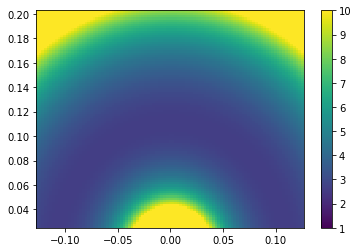

In [6]:
## Solve

M = np.array([[1, 0, 0, L1 + L2],
              [0, 1, 0,       0],
              [0, 0, 1,       0],
              [0, 0, 0,       1]])
S1 = np.array([0, 0, 1, 0, 0, 0])
S2 = np.array([0, 0, 1, 0, -L1, 0])
Slist = np.column_stack((S1, S2))

B1 = np.array([0, 0, 1, 0, L1+L2, 0])
B2 = np.array([0, 0, 1, 0, L2, 0])
Blist = np.column_stack((B1, B2))

num_x = 100
num_y = 100
data = np.zeros((num_y, num_x))

x_locs = np.linspace(-W/2, W/2, num_x).tolist()
y_locs = np.linspace(B, B+H, num_y).tolist()

for i in range(num_x):
    for j in range(num_y):
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x_locs[i], y_locs[j], L1, L2)
        # Calculate Jacobian Matrix
        Jb = mr.JacobianBody(Blist, thetalist)
        # Take Linear Velocity portion
        Jv = Jb[3:, :]
        # Calculate A matrix
        A = np.matmul(Jv, Jv.T)
        # Find eigenvalues of matrix
        eig_vals = np.linalg.eigvals(A).flatten()
        eig_vals = eig_vals[eig_vals > 0]
        data[j,i] = np.max(eig_vals) / np.min(eig_vals) 

import matplotlib.pyplot as plt
fig = plt.figure()
plt.pcolormesh(x_locs, y_locs, data, vmin=1, vmax=10)
plt.colorbar()

plt.show(fig)

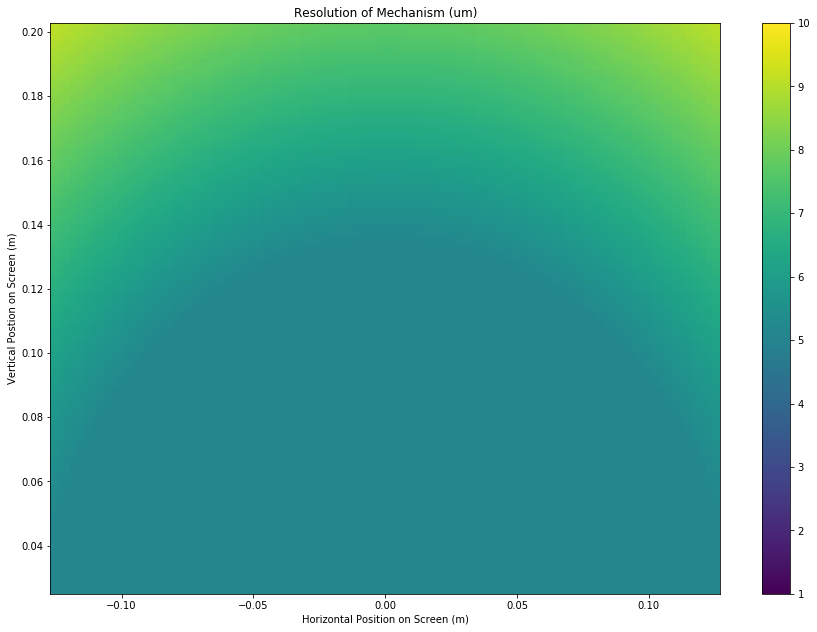

In [32]:
motor_torque = 0.6  # N-m
gear_ratio = 10

num_steps = 8192 # resolution of encoder
step_angle = pi/num_steps/gear_ratio #rad

res = np.zeros((num_y, num_x))

for i in range(num_x):
    for j in range(num_y):
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x_locs[i], y_locs[j], L1, L2)
        # Calculate Jacobian Matrix
        Jb = mr.JacobianBody(Blist, thetalist)
        # Find Twists from step in either joint
        Vb1 = np.matmul(Jb, np.array([[step_angle], [0]]))
        Vb2 = np.matmul(Jb, np.array([[0], [step_angle]]))
        # Calculate euclidean distance as resolution
        res1 = (Vb1[3]**2 + Vb1[4]**2)**0.5
        res2 = (Vb2[3]**2 + Vb2[4]**2)**0.5
        # Store as data
        if res1 > res2: res[j,i] = res1*1000000
        else: res[j,i] = res2*1000000

import matplotlib.pyplot as plt
fig = plt.figure()
plt.pcolormesh(x_locs, y_locs, res, vmin=1, vmax=10)
plt.colorbar()
plt.gcf().set_size_inches(15, 10.5)
plt.title('Resolution of Mechanism (um)')
plt.xlabel('Horizontal Position on Screen (m)')
plt.ylabel('Vertical Postion on Screen (m)')
plt.show(fig)




In [18]:
motor_inertia = 48.018472 #g-cm2
gear_ratio = 6

motor_reflected_inertia = motor_inertia * gear_ratio**2

moment_arm_length = 20 #cm
effective_inertia = motor_reflected_inertia / moment_arm_length**2
print(f'Effective inertia = {effective_inertia} g')

con_torque = 0.2 #N-m
out_torque = con_torque * gear_ratio #N-m
f_tip = out_torque / moment_arm_length * 100 #N
print(f'Continous output force = {f_tip} N')

Effective inertia = 4.32166248 g
Continous output force = 6.000000000000001 N
